In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [15]:
config = {
    "base_dir":        "/storage/vbsjjlnu/VBSjjlnu_v7/",
    "plot_config":     "FullRun2_v7",
    "cut":             "res_sig",
    "model_version":   "v2_e",
}

In [16]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

import yaml
model_config_file = open(model_dir + "/model_config.yml", "r")
model_config = yaml.safe_load(model_config_file)

for key in ["samples_version", "cols"]:
    config[key] = model_config[key]

In [17]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [18]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [20]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight"]).values
Wnn_bkg = (bkg["weight"]).values

X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

scaler = pickle.load(open(f"{model_dir}/scaler_model.pkl", "rb"))
X_scaled = scaler.fit_transform(X)

## Keras model

In [21]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow as tf 

model = tf.keras.models.load_model(os.path.join(model_dir, "model.h5"))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1280      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [22]:
type(model)

tensorflow.python.keras.engine.sequential.Sequential

# SHAP

In [23]:
import shap

shap.initjs()

In [24]:
sample_indexes = np.random.choice(X_scaled.shape[0], 1000, replace=False)
select = np.in1d(range(X_scaled.shape[0]), sample_indexes )  

In [25]:
e = shap.DeepExplainer(model, X_scaled[select])

In [26]:
X = pd.DataFrame(X_scaled[~select][:1000],  columns=config["cols"])
shap_values = e.shap_values(X.values)

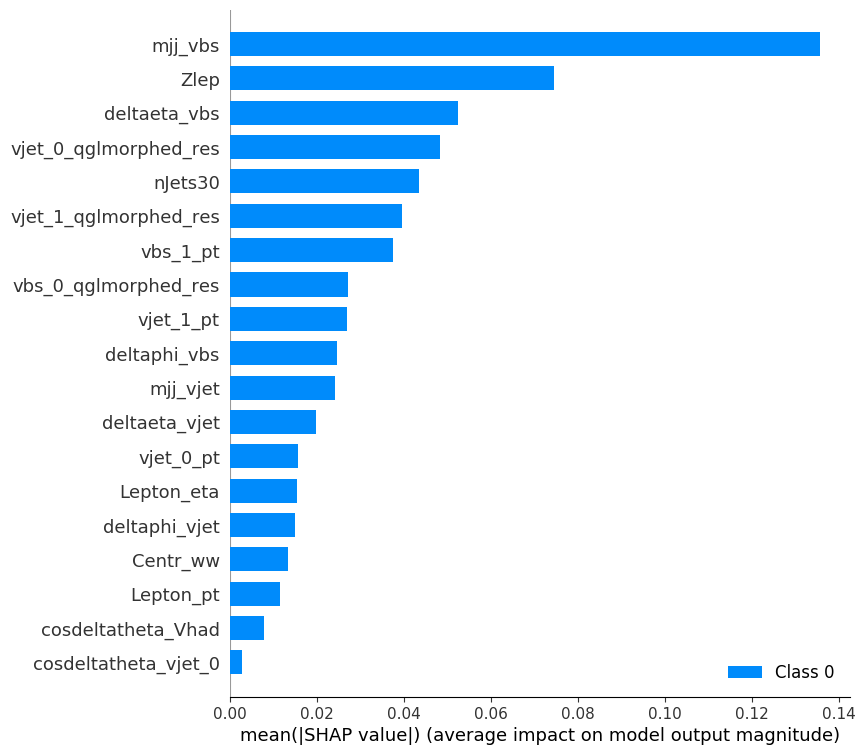

In [27]:
shap.summary_plot(shap_values, X, max_display=30)

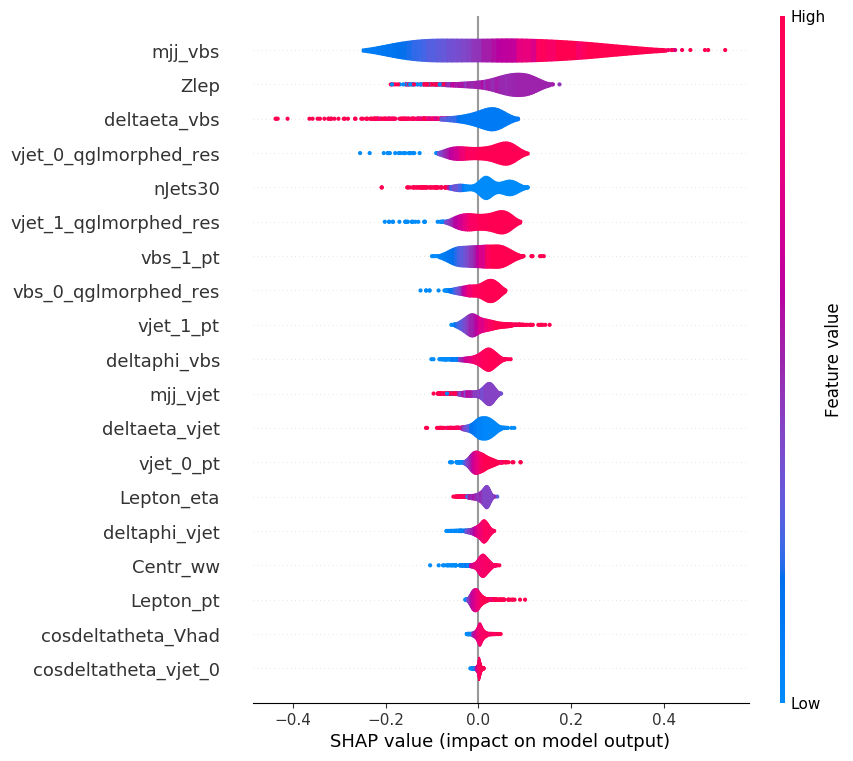

In [28]:
shap.summary_plot(shap_values[0], X, max_display=40, plot_type="violin")

### Evaluation

In [465]:
X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = \
            train_test_split(X_scaled, Y,  W, Wnn, test_size=0.15, random_state=41, stratify=Y)


#X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=config["val_size"]) ## test != val

>>> Computing AUC...


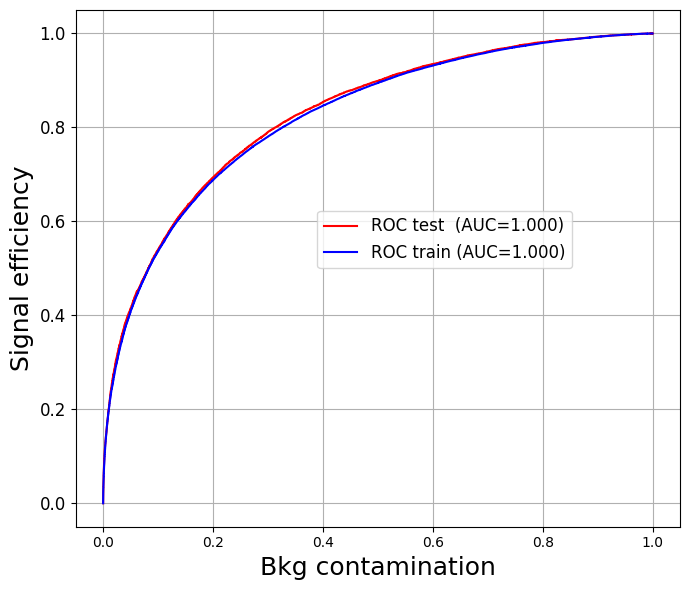

In [466]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve, auc


pred_test  = model.predict(X_test,  batch_size=2048)
pred_train = model.predict(X_train, batch_size=2048)
#auc_w_test  = roc_auc_score(y_test, pred_test,  sample_weight=W_test)
#auc_w_train = roc_auc_score(y_train,pred_train, sample_weight=W_train)
fpW_test,  tpW_test,  thW_test  = roc_curve(y_test,  pred_test , sample_weight=Wnn_test)
fpW_train, tpW_train, thW_train = roc_curve(y_train, pred_train, sample_weight=Wnn_train)
#auc_w_test = auc(fpW_test,tpW_test)
#auc_w_train = auc(fpW_train,tpW_train)
auc_w_test = 1
auc_w_train = 1
#print("AUC score: " + str(auc))

fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

# ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
ax1.plot(fpW_test,  tpW_test,  label=f"ROC test  (AUC={auc_w_test:.3f})", color="red")
ax1.plot(fpW_train, tpW_train, label=f"ROC train (AUC={auc_w_train:.3f})", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

ax1.legend(loc=(0.4, 0.5), fontsize="large")

fig.tight_layout()

plt.savefig(model_dir+"/roc_total.png")

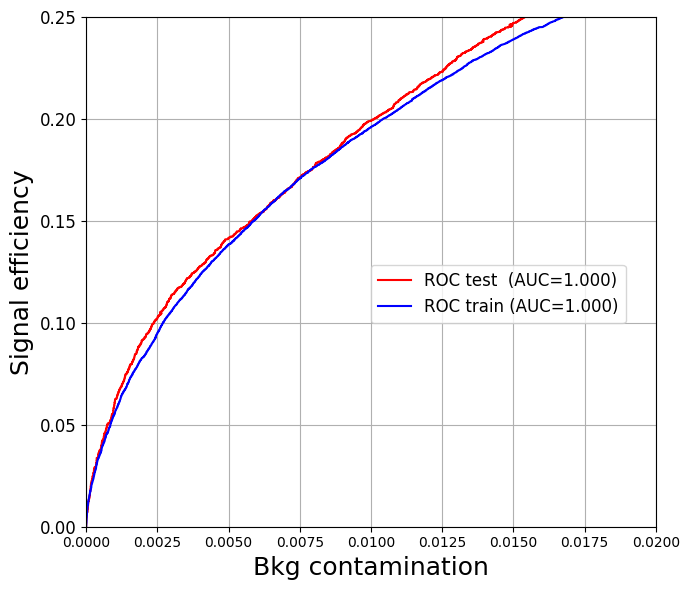

In [467]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

# ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
ax1.plot(fpW_test,  tpW_test,  label=f"ROC test  (AUC={auc_w_test:.3f})", color="red")
ax1.plot(fpW_train, tpW_train, label=f"ROC train (AUC={auc_w_train:.3f})", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

ax1.legend(loc=(0.5, 0.4), fontsize="large")

ax1.set_xlim(0,0.02)
ax1.set_ylim(0,0.25)

fig.tight_layout()

plt.savefig(model_dir+"/roc_zoom.png")

## Save notebook

In [447]:
import os

notebook_name = 'Evaluate_SHAP_res.ipynb'
file_name = 'Evaluate_SHAP_res.html'

import sys
!rm $model_dir/$file_name
!{sys.executable} -m jupyter nbconvert --to html $notebook_name --output $model_dir/$file_name

#print(os.getcwd())
#print(os.listdir(os.getcwd()))
#print("rsync Evaluate_SHAP_boost.html lxplus.cern.ch:" + model_dir + "/Evaluate_SHAP_boost.html; mv Evaluate_SHAP_boost.html Evaluate_SHAP_boost.html_old" )

#os.rename('Evaluate_ANOVA_SHAP.html', model_dir + "/Evaluate_ANOVA_SHAP.html")
#print(model_dir + "/Evaluate_ANOVA_SHAP.html")

rm: cannot remove '/storage/vbsjjlnu/VBSjjlnu_v7/FullRun2_v7/res_sig/models/v11_e/Evaluate_SHAP_res.html': No such file or directory
[NbConvertApp] Converting notebook Evaluate_SHAP_res.ipynb to html
[NbConvertApp] Writing 1305599 bytes to /storage/vbsjjlnu/VBSjjlnu_v7/FullRun2_v7/res_sig/models/v11_e/Evaluate_SHAP_res.html


# Some DNN distribution plots

In [26]:
bkg["y"] = model.predict(scaler.transform(bkg[config["cols"]].values), batch_size=2048)

In [27]:
signal["y"] = model.predict(scaler.transform(signal[config["cols"]].values), batch_size=2048)

In [31]:
wjets = bkg[bkg["sample_name"] == "Wjets_HT"]
top = bkg[bkg["sample_name"] == "top"]
dy = bkg[bkg["sample_name"] == "DY"]

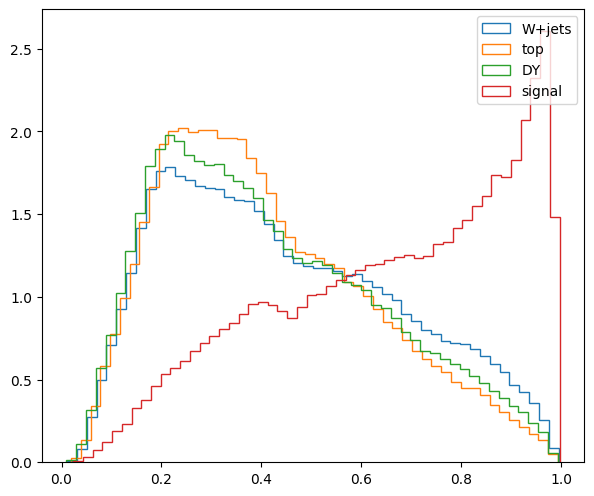

In [32]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(bkg[bkg["sample_name"] == "Wjets_HT"]["y"], bins=50, density=True, label="W+jets", histtype="step")
plt.hist(bkg[bkg["sample_name"] == "top"]["y"],   bins=50, density=True, label="top",    histtype="step")
plt.hist(bkg[bkg["sample_name"] == "DY"]["y"],    bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()

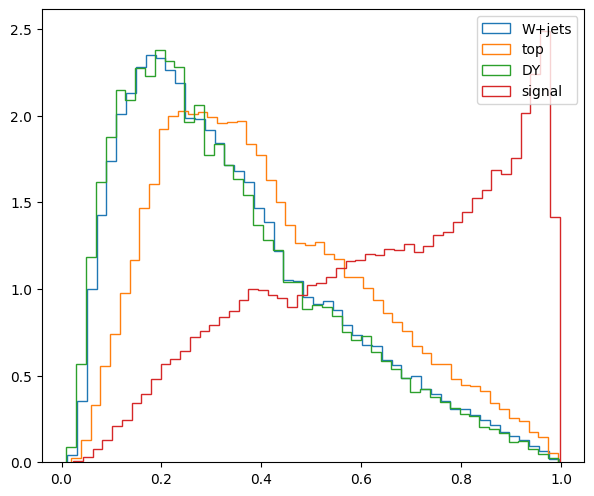

In [33]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(wjets["y"], weights=wjets.weight_norm, bins=50, density=True, label="W+jets", histtype="step")
plt.hist(top["y"],   weights=top.weight_norm,  bins=50, density=True, label="top",    histtype="step")
plt.hist(dy["y"],    weights=dy.weight_norm,  bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], weights=signal.weight_norm, bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()

Text(0, 0.5, 'DeltaEta VBS')

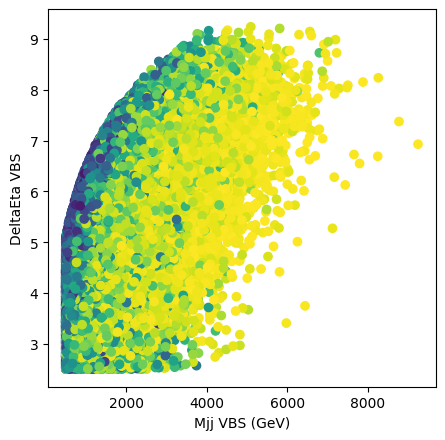

In [30]:
fig = plt.figure(figsize=(5,5))
plt.scatter(signal.mjj_vbs, signal.deltaeta_vbs, c=signal.y)
plt.xlabel("Mjj VBS (GeV)")
plt.ylabel("DeltaEta VBS")

In [39]:
import seaborn as sns
sns.set(style="white")

invalid value encountered in true_divide


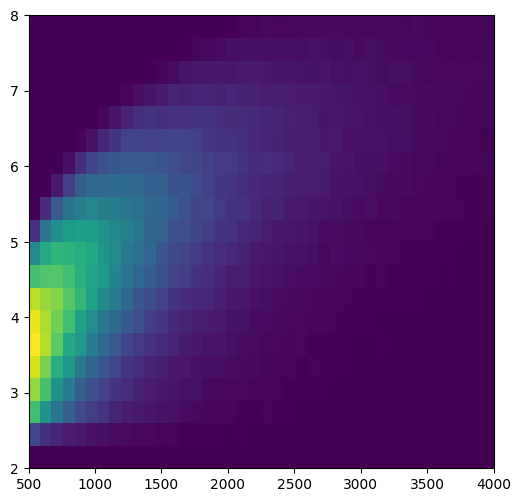

In [32]:
yrange= [2,8]
xrange= [500,4000]

b = plt.hist2d(signal.mjj_vbs,signal.deltaeta_vbs, range=[xrange, yrange], weights= signal.y, bins=(40,20), cmap="viridis")
a = plt.hist2d(signal.mjj_vbs,signal.deltaeta_vbs,range=[xrange, yrange], bins=(40,20), cmap="viridis")

c = b[0] / a[0]


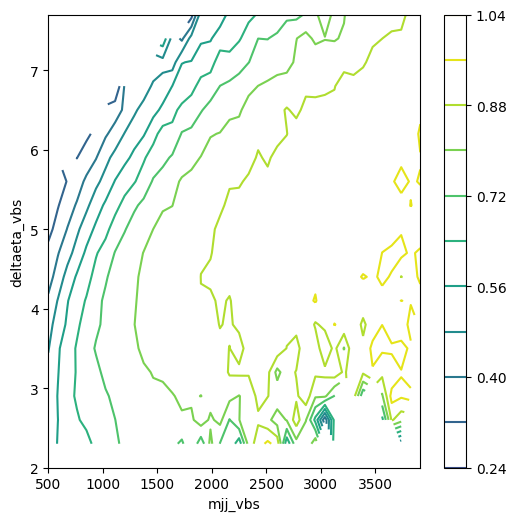

In [33]:
plt.contour(a[1][:-1],a[2][:-1], c.T, levels=10, vmax=1, vmin=0)
plt.xlabel("mjj_vbs")
plt.ylabel("deltaeta_vbs")
plt.colorbar()